# 将上海市旅游数据月分为日

## 1.数据准备
原则：将之前预测的2019全年数据分配作为上海市旅游入境疫情前全年数据日分配，2020-2024依照异常数据处理原则每年一分配

In [10]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_series(df, title='Time Series Data', xlabel='Date', ylabel='Value', figsize=(10, 6)):
    """
    绘制一个或多个时序数据的函数。
    
    参数:
    - df: 一个pandas DataFrame，索引为日期时间类型，每一列是一个时间序列。
    - title: 图表的标题。
    - xlabel: x轴的标签。
    - ylabel: y轴的标签。
    - figsize: 图表的尺寸，以英寸为单位。
    """
    plt.figure(figsize=figsize)
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


# 创建数据库引擎
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

imputed_data_query = f"SELECT date,CN_airport_departure FROM hk_customs_daily_imputed"
df = pd.read_sql_query(imputed_data_query, engine, index_col='date',parse_dates=['date'])

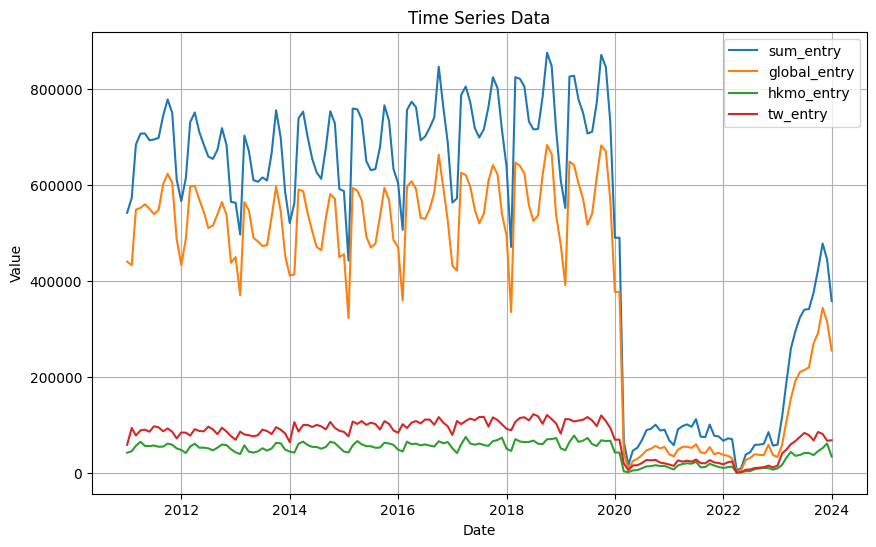

In [11]:
raw_data_query = f"SELECT * FROM sh_customs"
sh_monthly = pd.read_sql_query(raw_data_query, engine, index_col='date',parse_dates=['date'])

# 确定最后一个月的最后一天
last_month = sh_monthly.index.max().to_period('M').to_timestamp('M')

# 生成到最后一个月最后一天的完整日期范围，避免最后一个月没有值
full_date_range = pd.date_range(start=sh_monthly.index.min(), end=last_month, freq='D')

# 重采样并前向填充
sh_daily_fake = sh_monthly.reindex(full_date_range).ffill()

plot_time_series(sh_monthly)

# 02 非疫情数据插值

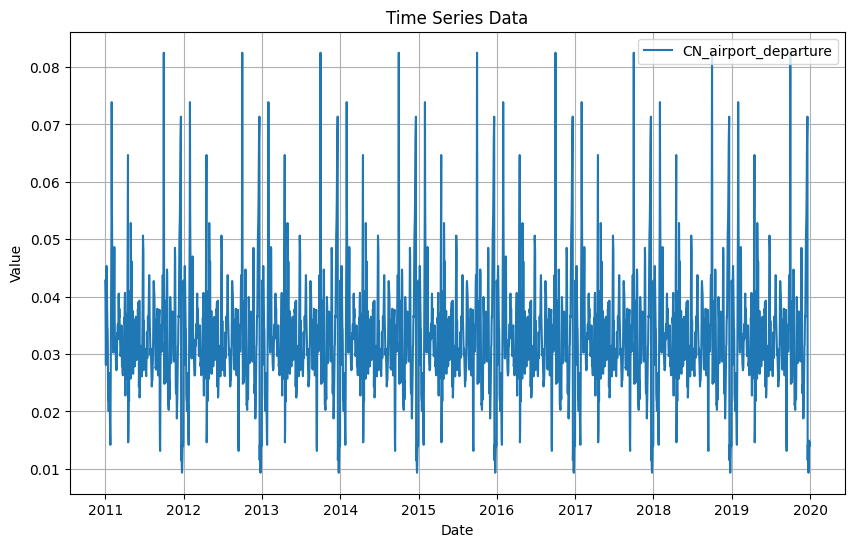

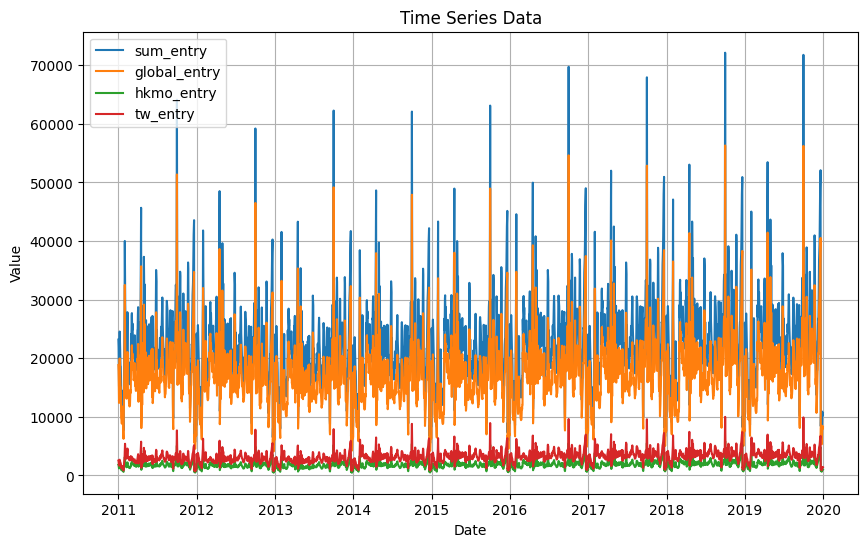

In [12]:
import pandas as pd
import numpy as np


# 假设df是2019年的每日数据DataFrame，其中有一个列名为'Ratio'
# 示例数据
dates_2019 = pd.date_range(start='2019-01-01', end='2019-12-31')
df_2019 = df['2019-01-01':'2019-12-31']


# 生成2011-2019年的每日DataFrame
years = range(2011, 2020)
frames = []  # 存储每年DataFrame的列表

for year in years:
    # 复制2019年数据，更新年份
    df_temp = df_2019.copy()
    df_temp.index = df_temp.index.map(lambda x: x.replace(year=year))
    
    # 处理闰年，添加2月29日
    if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):  # 判断闰年
        feb_28 = df_temp.loc[f'{year}-02-28']
        # 插入2月29日，比例与前一天相同
        df_temp = pd.concat([
            df_temp[:f'{year}-02-28'], 
            pd.DataFrame({'CN_airport_departure': [feb_28['CN_airport_departure']]}, index=[pd.Timestamp(f'{year}-02-29')]), df_temp[f'{year}-02-29':]
        ])
    
    frames.append(df_temp)

# 合并所有年份的DataFrame
result = pd.concat(frames)

data_std = np.std(result.values)
# 设置噪声标准差为原始数据标准差的5%
noise_std = 0.3 * data_std
# 生成高斯噪声
noise = np.random.normal(0, noise_std, result.shape)
# 将噪声添加到原始数据
noisy_data = result + noise

# 计算每个月的总和
# 初始化一个新的DataFrame来存储每日比例数据
reg_ratio = pd.DataFrame(index=result.index)
# 对于df中的每一列，计算每日比例
for column in result.columns:
    # 对于每个月，计算该月每一天的值占该月总和的比例
    reg_ratio[column] = result[column] / result[column].resample('ME').transform('sum')


plot_time_series(reg_ratio)

sh_reg_slice = sh_daily_fake['2011-01-01':'2019-12-31']
sh_daily_regular = sh_reg_slice.multiply(reg_ratio['CN_airport_departure'],axis=0).astype('int')

    # 打印含噪声的数据
plot_time_series(sh_daily_regular)

# 03 疫情期间数据插值

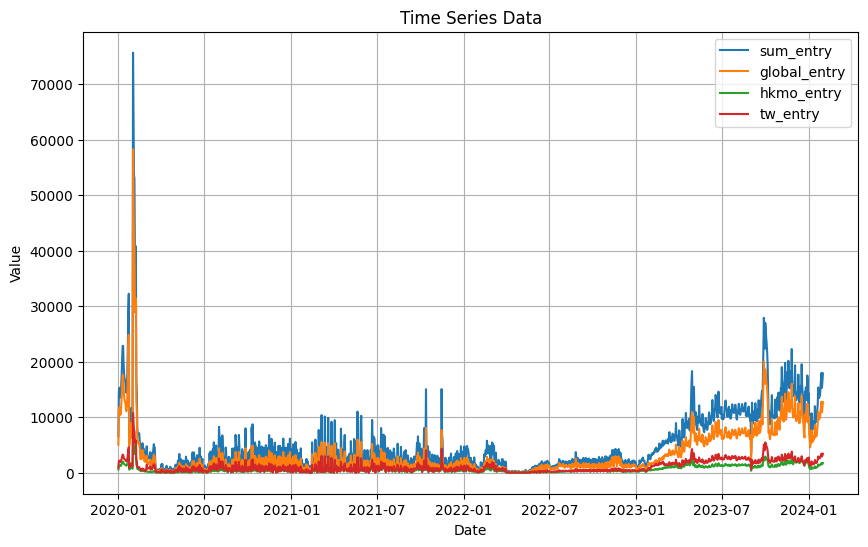

In [13]:
# 初始化一个新的DataFrame来存储每日比例数据
daily_ratio = pd.DataFrame(index=df.index)
# 对于df中的每一列，计算每日比例
for column in df.columns:
    # 对于每个月，计算该月每一天的值占该月总和的比例
    daily_ratio[column] = df[column] / df[column].resample('ME').transform('sum')
special_slice_start = '2020-01-01'
special_slice_end = '2024-01-31'

epd_range = pd.date_range(start=pd.to_datetime(special_slice_start), end=pd.to_datetime(special_slice_end))

special_ratio = daily_ratio[special_slice_start:special_slice_end]

# 为每个 DataFrame 创建年份和月份的列

sh_daily_fake_epd = sh_daily_fake.loc[epd_range]

# 使用pandas广播机制
sh_daily_epd = sh_daily_fake_epd.multiply(special_ratio['CN_airport_departure'],axis=0).astype('int')

plot_time_series(sh_daily_epd)

# 04 数据合并

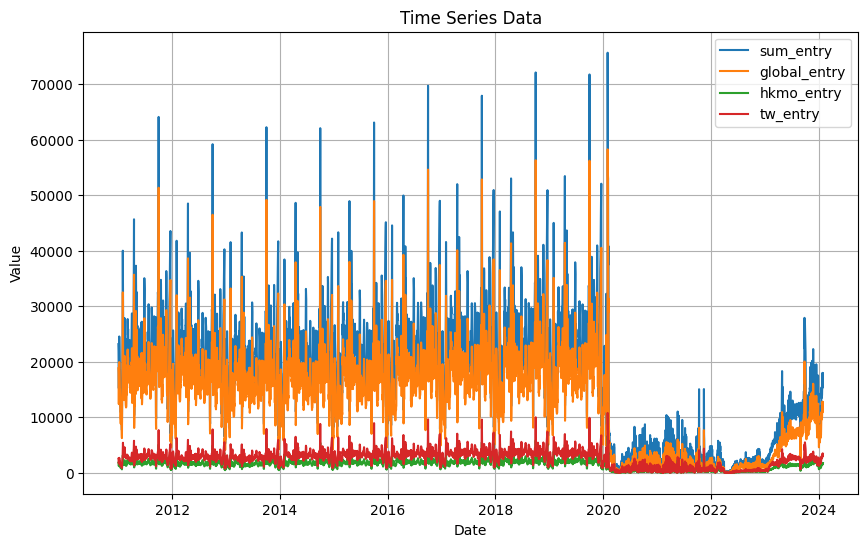

In [14]:
sh_daily_imputed = pd.concat([sh_daily_regular,sh_daily_epd])

plot_time_series(sh_daily_imputed)

In [16]:
sh_daily_imputed.to_sql('sh_customs_daily_imputed', con=engine,index=True,index_label='date', if_exists='replace')

4779